In [7]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans

perfumes_df = pd.read_csv("../data_csv/perfumes_table.csv")

des_df = pd.read_csv("../data_csv/description_embedding.csv", header=None)
rev_df = pd.read_csv("../data_csv/reviews_embeddings.csv", header=None)

print("perfumes_df:", perfumes_df.shape)
print("des_df:", des_df.shape)
print("rev_df:", rev_df.shape)

des_df.head(), rev_df.head()

perfumes_df: (84144, 7)
des_df: (82478, 3)
rev_df: (82478, 3)


(                                                   0            1  \
 0  https://www.fragrantica.com/perfume/Bourjois/F...  description   
 1  https://www.fragrantica.com/perfume/Estee-Laud...  description   
 2  https://www.fragrantica.com/perfume/Bottega-Ve...  description   
 3  https://www.fragrantica.com/perfume/WienerBlut...  description   
 4  https://www.fragrantica.com/perfume/Giorgio-Be...  description   
 
                                                    2  
 0  [-0.016037703,0.002452367,-0.034618597,-0.0227...  
 1  [-0.014782463,0.0033083311,-0.003350998,-0.005...  
 2  [-0.016479159,-0.003288894,0.0009828688,-0.018...  
 3  [-0.015022586,-0.014174221,-0.008685952,-0.030...  
 4  [-0.02203009,-0.007923215,-0.008837432,-0.0299...  ,
                                                    0        1  \
 0  https://www.fragrantica.com/perfume/Bourjois/F...  reviews   
 1  https://www.fragrantica.com/perfume/Estee-Laud...  reviews   
 2  https://www.fragrantica.com/perfume/Bot

In [8]:
des_embeddings = des_df.iloc[:, 2].apply(ast.literal_eval).to_list()
rev_embeddings = rev_df.iloc[:, 2].apply(ast.literal_eval).to_list()

desc_vec = np.vstack(des_embeddings).astype("float32")
rev_vec  = np.vstack(rev_embeddings).astype("float32")

n = min(desc_vec.shape[0], rev_vec.shape[0], rev_df.shape[0], des_df.shape[0])
desc_vec = desc_vec[:n]
rev_vec  = rev_vec[:n]

reviews_text = rev_df.iloc[:n, 1].astype(str).str.lower()
urls = rev_df.iloc[:n, 0].astype(str)

print("aligned n:", n)
print("desc_vec:", desc_vec.shape, "rev_vec:", rev_vec.shape)
print("reviews_text null ratio:", reviews_text.isna().mean())
reviews_text.head()

aligned n: 82478
desc_vec: (82478, 1536) rev_vec: (82478, 1536)
reviews_text null ratio: 0.0


0    reviews
1    reviews
2    reviews
3    reviews
4    reviews
Name: 1, dtype: object

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_11650/557857709.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_rate = failure_flag.groupby(bins).mean()


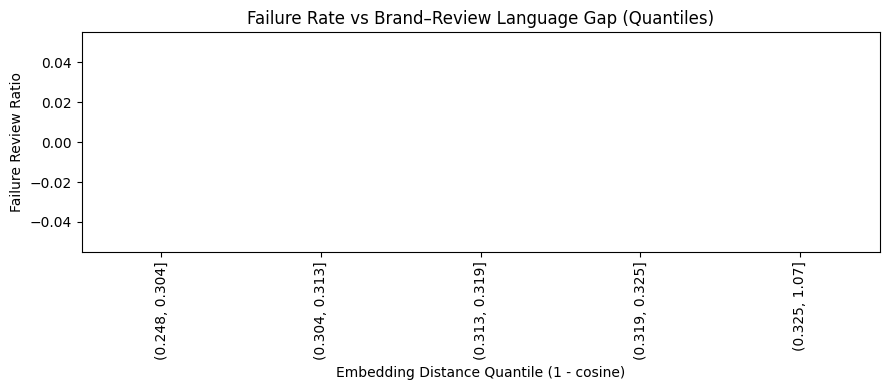

overall failure rate: 0.0
distance summary: count    82478.000000
mean         0.314582
std          0.020291
min          0.249404
25%          0.306588
50%          0.315792
75%          0.323134
max          1.070418
dtype: float64


In [9]:
# Brand Language vs Consumer Reality: Language Gap Distance + Failure Keyword Overlay

desc_norm = normalize(desc_vec, norm="l2")
rev_norm  = normalize(rev_vec,  norm="l2")

cos_sim = np.sum(desc_norm * rev_norm, axis=1)
distance = 1.0 - cos_sim

failure_keywords = [
    "disappointed", "regret", "headache", "sick", "metallic",
    "too strong", "overpowering", "nausea", "nauseating", "suffocating",
    "cloying", "migraine"
]

failure_flag = reviews_text.apply(lambda x: any(k in x for k in failure_keywords)).astype(bool)

bins = pd.qcut(distance, q=5, duplicates="drop")
failure_rate = failure_flag.groupby(bins).mean()

plt.figure(figsize=(9, 4))
failure_rate.plot(kind="bar")
plt.title("Failure Rate vs Brand–Review Language Gap (Quantiles)")
plt.ylabel("Failure Review Ratio")
plt.xlabel("Embedding Distance Quantile (1 - cosine)")
plt.tight_layout()
plt.show()

print("overall failure rate:", float(failure_flag.mean()))
print("distance summary:", pd.Series(distance).describe())

In [10]:
# Olfactory Shadowing: Failure Review Cluster Extraction

fail_mask = failure_flag.values
fail_embeddings = rev_vec[fail_mask]
fail_reviews = reviews_text[fail_mask].reset_index(drop=True)
fail_urls = urls[fail_mask].reset_index(drop=True)

print("Fail review count:", fail_embeddings.shape[0])

if fail_embeddings.shape[0] >= 50:
    k = 5
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096, n_init="auto")
    labels = km.fit_predict(fail_embeddings)

    fail_cluster = pd.DataFrame({
        "cluster": labels,
        "url": fail_urls,
        "text": fail_reviews
    })

    display(fail_cluster.groupby("cluster").head(5))

    cluster_sizes = fail_cluster["cluster"].value_counts().sort_index()
    plt.figure(figsize=(8, 3))
    cluster_sizes.plot(kind="bar")
    plt.title("Failure Clusters (sizes)")
    plt.ylabel("count")
    plt.xlabel("cluster")
    plt.tight_layout()
    plt.show()
else:
    print("Fail count too small for clustering. (need >= 50)")

Fail review count: 0
Fail count too small for clustering. (need >= 50)


Exception count: 29572
Novelty summary:
 count    82478.000000
mean         0.082697
std          0.035945
min          0.049161
25%          0.052301
50%          0.066536
75%          0.126643
max          1.071869
dtype: float64
Local density summary:
 count    8.247800e+04
mean     1.886099e-04
std      1.352310e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.384186e-07
max      9.910399e-01
dtype: float64
Extreme text rate: 0.0


,url,novelty,local_density,pos_score,neg_score,len,text
25547,https://www.fragrantica.com/perfume/Bath-Body-...,1.071869,0.984173,0,0,7,reviews
12660,https://www.fragrantica.com/perfume/Ahmed-Al-M...,1.034860,0.985679,0,0,7,reviews
13524,https://www.fragrantica.com/perfume/Avon/Trail...,1.032936,0.991040,0,0,7,reviews
781,https://www.fragrantica.com/perfume/Phebo/Nect...,1.026665,0.989639,0,0,7,reviews
376,https://www.fragrantica.com/perfume/Marbert/En...,1.022633,0.974780,0,0,7,reviews
1055,https://www.fragrantica.com/perfume/Le-Chameau...,1.022596,0.987241,0,0,7,reviews
22243,https://www.fragrantica.com/perfume/Foamous/Ra...,1.016705,0.977094,0,0,7,reviews
12518,https://www.fragrantica.com/perfume/Wood-Moss/...,1.006822,0.982314,0,0,7,reviews
22082,https://www.fragrantica.com/perfume/A-Wing-A-P...,1.005730,0.972154,0,0,7,reviews
9398,https://www.fragrantica.com/perfume/Cacharel/A...,0.996497,0.966396,0,0,7,reviews


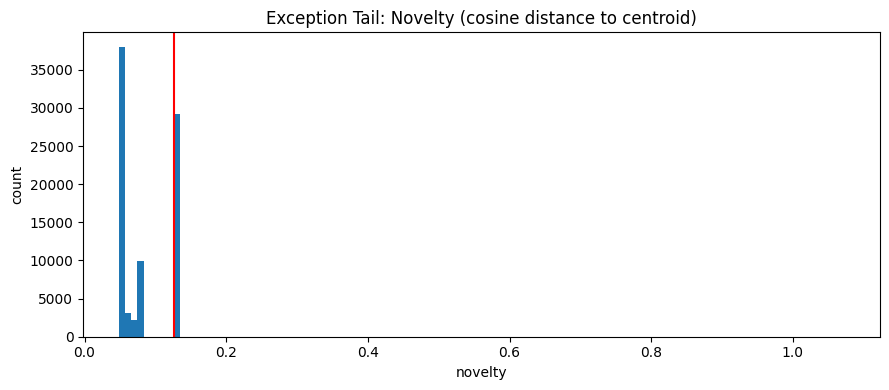

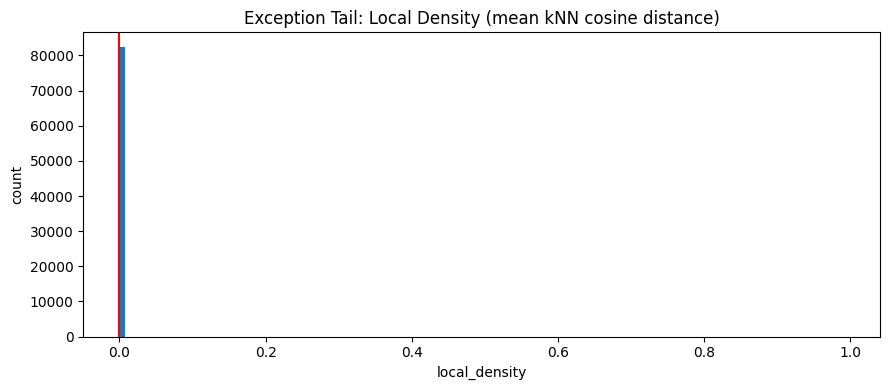

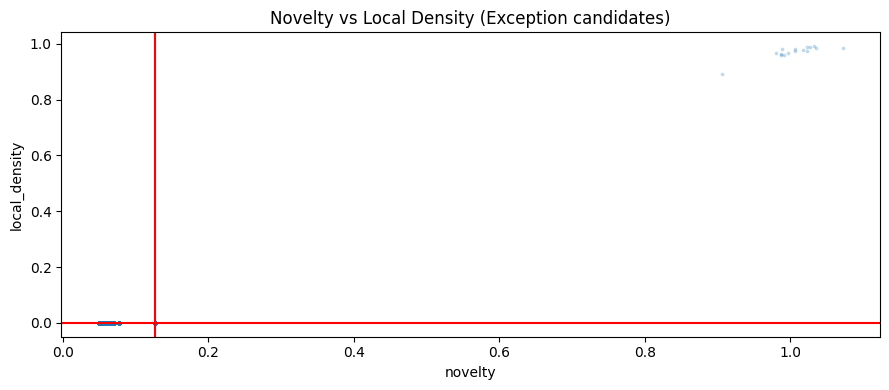

In [13]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

rev_norm = normalize(rev_vec, norm="l2")
centroid = normalize(rev_norm.mean(axis=0, keepdims=True), norm="l2")
novelty = 1.0 - np.sum(rev_norm * centroid, axis=1)

k = 11
nn = NearestNeighbors(n_neighbors=k, metric="cosine", algorithm="auto")
nn.fit(rev_norm)
dists, _ = nn.kneighbors(rev_norm)
local_density = dists[:, 1:].mean(axis=1)  # self 제외

pos_kw = ["love", "obsessed", "signature", "perfect", "masterpiece", "gorgeous", "amazing"]
neg_kw = ["hate", "regret", "disappointed", "nausea", "nauseating", "headache", "migraine",
          "sick", "metallic", "sour", "overpowering", "too strong", "suffocating", "cloying"]

t = reviews_text.fillna("").astype(str).str.lower()

pos_score = t.apply(lambda x: sum(k in x for k in pos_kw))
neg_score = t.apply(lambda x: sum(k in x for k in neg_kw))
extreme_text = (pos_score >= 2) | (neg_score >= 2)

nov_hi  = np.quantile(novelty, 0.95)
dens_hi = np.quantile(local_density, 0.95)

exception_mask = (
    (novelty >= nov_hi) |
    (local_density >= dens_hi) |
    (extreme_text.values)
)

print("Exception count:", int(exception_mask.sum()))
print("Novelty summary:\n", pd.Series(novelty).describe())
print("Local density summary:\n", pd.Series(local_density).describe())
print("Extreme text rate:", float(extreme_text.mean()))

exception_df = pd.DataFrame({
    "url": urls[exception_mask].values,
    "novelty": novelty[exception_mask],
    "local_density": local_density[exception_mask],
    "pos_score": pos_score[exception_mask].values,
    "neg_score": neg_score[exception_mask].values,
    "len": t[exception_mask].str.len().values,
    "text": t[exception_mask].values
}).sort_values(["novelty", "local_density", "neg_score"], ascending=False)

display(exception_df.head(20))

plt.figure(figsize=(9, 4))
plt.hist(novelty, bins=120)
plt.axvline(nov_hi, color="r")
plt.title("Exception Tail: Novelty (cosine distance to centroid)")
plt.xlabel("novelty")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.hist(local_density, bins=120)
plt.axvline(dens_hi, color="r")
plt.title("Exception Tail: Local Density (mean kNN cosine distance)")
plt.xlabel("local_density")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.scatter(novelty, local_density, s=3, alpha=0.2)
plt.axvline(nov_hi, color="r")
plt.axhline(dens_hi, color="r")
plt.title("Novelty vs Local Density (Exception candidates)")
plt.xlabel("novelty")
plt.ylabel("local_density")
plt.tight_layout()
plt.show()

EDA 진행 불가로 일단 넘어감 -> 추후 활용 가능성 있음 
novelty (centroid distance), local_density (kNN)